# 🎵 Music Genre Classification

This notebook implements a multi-class music genre classifier using the GTZAN dataset.

## Approaches:
1. **Tabular ML** - Using pre-extracted audio features (MFCCs, spectral features, etc.)
2. **CNN** - Using mel spectrogram images
3. **Transfer Learning** - Using pre-trained models on spectrograms

## Dataset:
- 10 genres: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
- 100 tracks per genre (30 seconds each)
- Pre-extracted features in CSV format
- Mel spectrogram images (PNG)

## 1. Setup & Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path

# Preprocessing & ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

# ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2026-02-04 22:23:46.277175: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-04 22:23:46.435433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-04 22:23:49.674704: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


✅ Libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: False


2026-02-04 22:23:50.804969: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Data Loading & Exploration

In [2]:
# Define paths
DATA_DIR = Path('Data')
FEATURES_30_SEC = DATA_DIR / 'features_30_sec.csv'
FEATURES_3_SEC = DATA_DIR / 'features_3_sec.csv'
IMAGES_DIR = DATA_DIR / 'images_original'
AUDIO_DIR = DATA_DIR / 'genres_original'

# Load tabular data
df_30 = pd.read_csv(FEATURES_30_SEC)
df_3 = pd.read_csv(FEATURES_3_SEC)

print("=" * 60)
print("📊 Dataset Overview")
print("=" * 60)
print(f"\n30-second features: {df_30.shape[0]} samples, {df_30.shape[1]} columns")
print(f"3-second features: {df_3.shape[0]} samples, {df_3.shape[1]} columns")
print(f"\nGenres: {df_30['label'].unique().tolist()}")
print(f"Number of genres: {df_30['label'].nunique()}")

📊 Dataset Overview

30-second features: 1000 samples, 60 columns
3-second features: 9990 samples, 60 columns

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Number of genres: 10


In [3]:
# Display sample data
print("\n📋 Sample Data (30-second features):")
df_30.head()


📋 Sample Data (30-second features):


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
# Data info
print("\n📊 Data Types & Info:")
print(df_30.dtypes.value_counts())
print(f"\n Missing values: {df_30.isnull().sum().sum()}")


📊 Data Types & Info:
float64    57
str         2
int64       1
Name: count, dtype: int64

 Missing values: 0


In [5]:
# Statistical summary
print("\n📈 Statistical Summary:")
df_30.describe().T.head(20)


📈 Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
length,1000.0,6.620308e+05,1.784074e+03,6.600000e+05,661504.000000,6.617940e+05,6.617940e+05,6.758080e+05
chroma_stft_mean,1000.0,3.786817e-01,8.170489e-02,1.719392e-01,0.319562,3.831479e-01,4.359417e-01,6.636847e-01
chroma_stft_var,1000.0,8.633982e-02,7.735298e-03,4.455525e-02,0.082298,8.661463e-02,9.125551e-02,1.081115e-01
rms_mean,1000.0,1.309297e-01,6.568311e-02,5.276444e-03,0.086657,1.224431e-01,1.756822e-01,3.979734e-01
rms_var,1000.0,3.051399e-03,3.634500e-03,4.294372e-06,0.000942,1.816440e-03,3.577055e-03,2.767948e-02
spectral_centroid_mean,1000.0,2.201781e+03,7.159606e+02,5.700404e+02,1627.697311,2.209263e+03,2.691295e+03,4.435244e+03
spectral_centroid_var,1000.0,4.696916e+05,4.008995e+05,7.911251e+03,184350.530174,3.384862e+05,6.121479e+05,3.036843e+06
spectral_bandwidth_mean,1000.0,2.242541e+03,5.263165e+02,8.980662e+02,1907.240605,2.221393e+03,2.578470e+03,3.509646e+03
spectral_bandwidth_var,1000.0,1.370792e+05,9.645567e+04,1.078719e+04,67376.554428,1.119775e+05,1.823716e+05,6.947848e+05
rolloff_mean,1000.0,4.571549e+03,1.574792e+03,7.491406e+02,3380.069642,4.658524e+03,5.533810e+03,8.677673e+03


### 2.1 Class Distribution

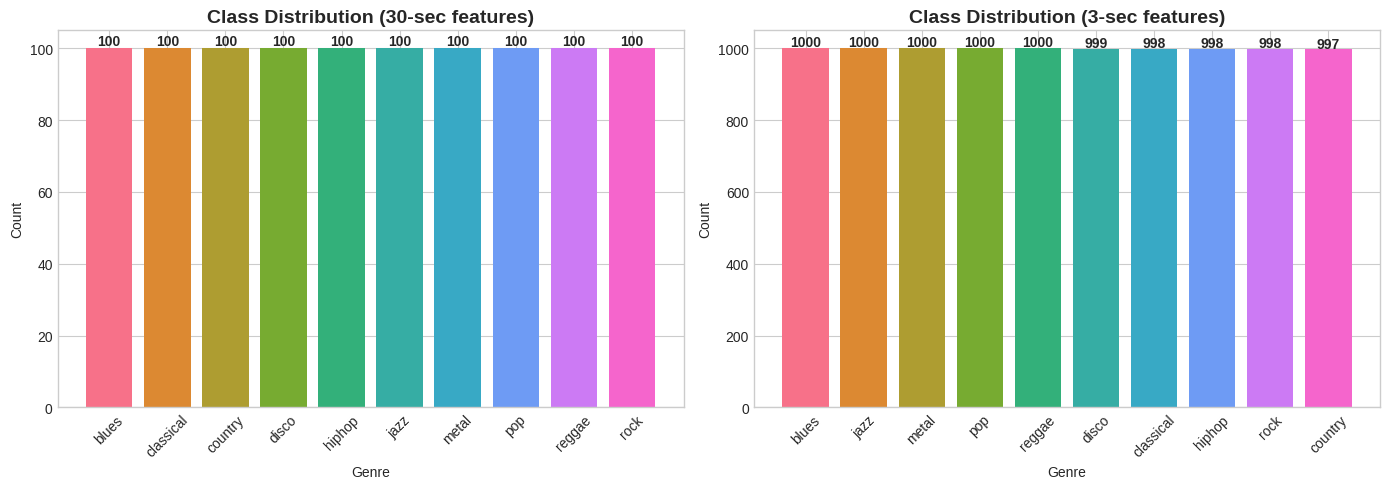


✅ Dataset is perfectly balanced with 100 samples per genre (30-sec)
✅ 3-sec dataset has ~999 samples per genre (10 segments per track)


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 30-second data distribution
genre_colors = sns.color_palette('husl', n_colors=10)
genre_counts_30 = df_30['label'].value_counts()
axes[0].bar(genre_counts_30.index, genre_counts_30.values, color=genre_colors)
axes[0].set_title('Class Distribution (30-sec features)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(genre_counts_30.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 3-second data distribution
genre_counts_3 = df_3['label'].value_counts()
axes[1].bar(genre_counts_3.index, genre_counts_3.values, color=genre_colors)
axes[1].set_title('Class Distribution (3-sec features)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(genre_counts_3.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Dataset is perfectly balanced with 100 samples per genre (30-sec)")
print("✅ 3-sec dataset has ~999 samples per genre (10 segments per track)")

### 2.2 Feature Correlation Analysis

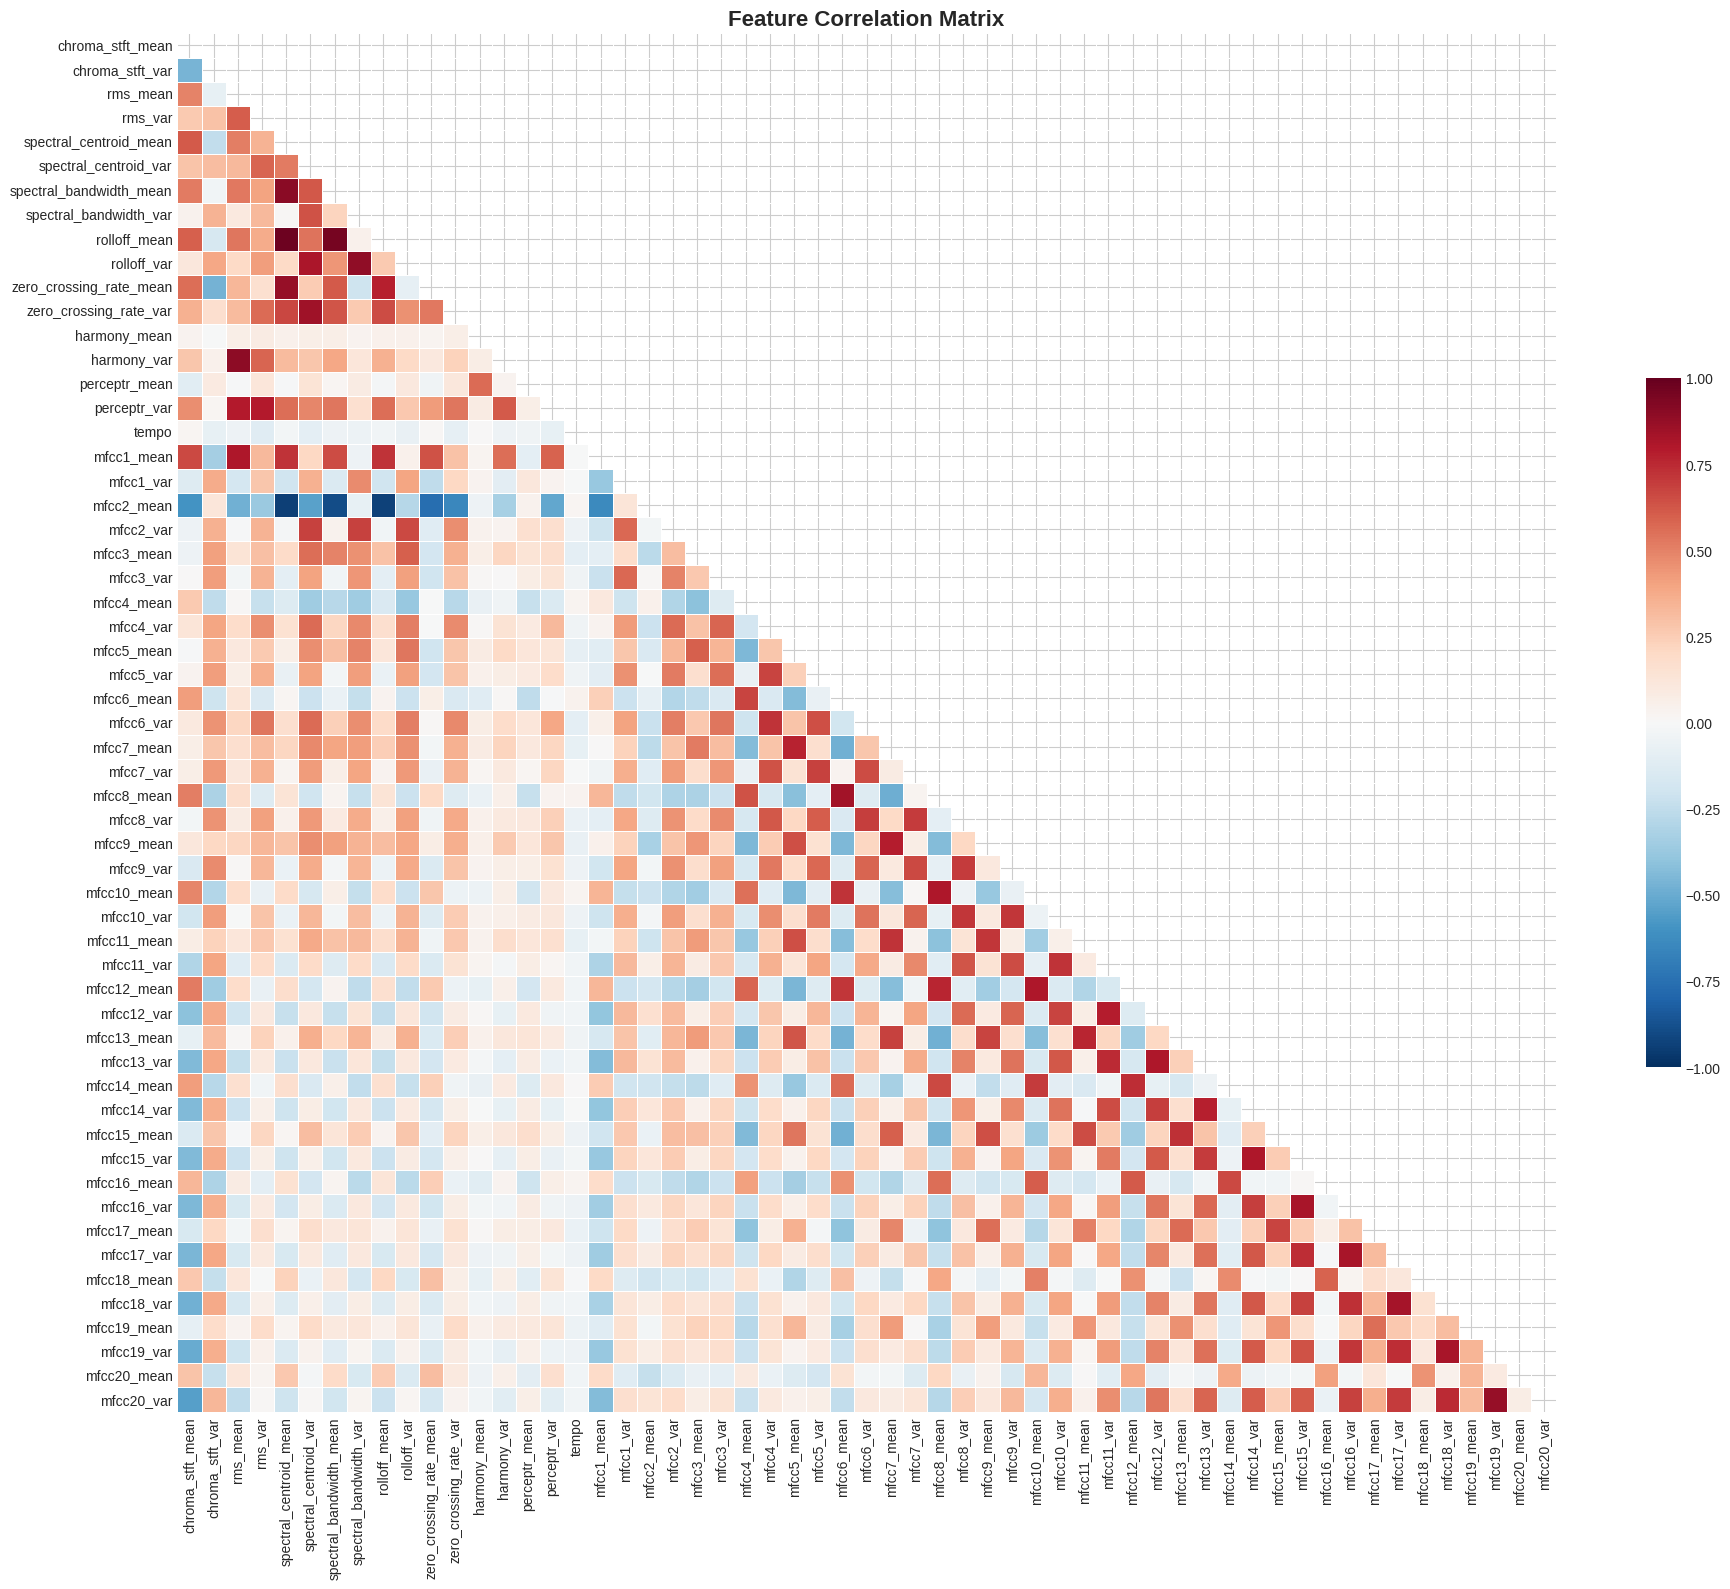

In [7]:
# Select numeric features for correlation analysis
numeric_cols = df_30.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('length')  # Remove constant column

# Compute correlation matrix
corr_matrix = df_30[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.3 MFCC Feature Analysis

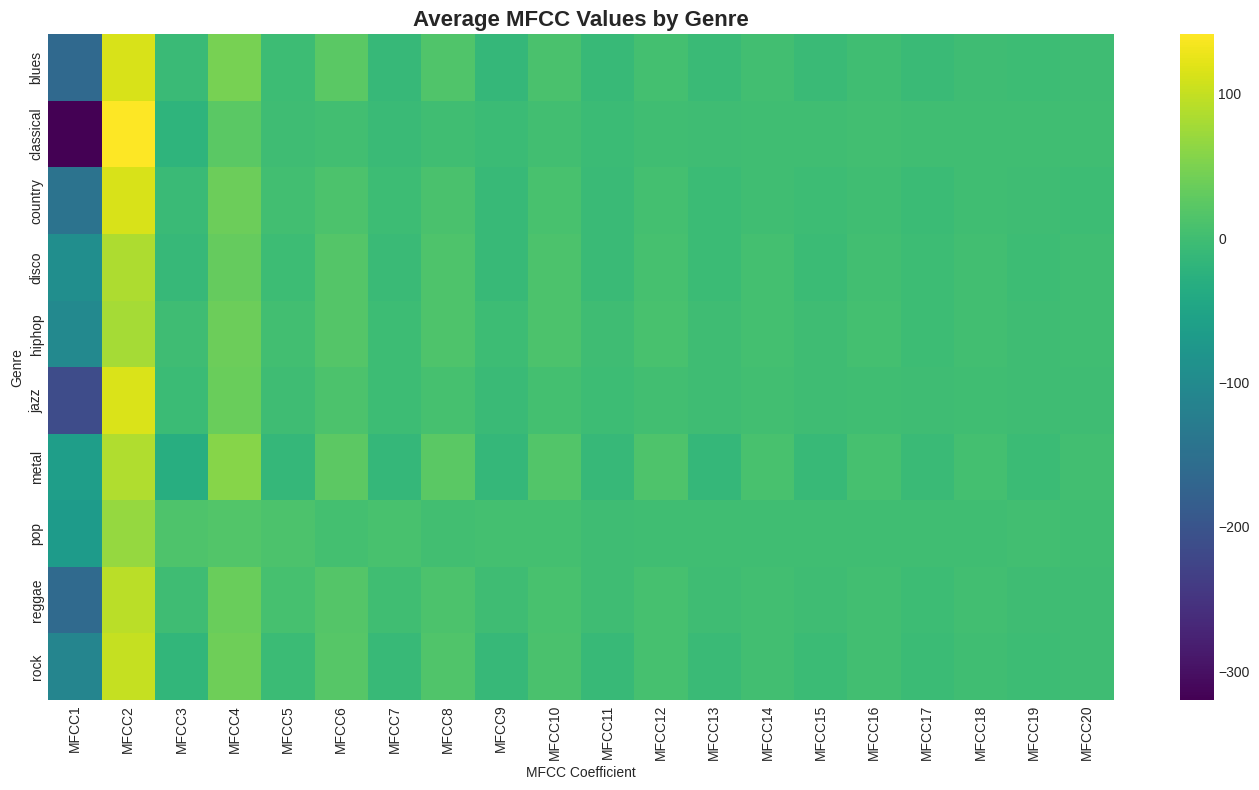

In [8]:
# Extract MFCC means for each genre
mfcc_cols = [f'mfcc{i}_mean' for i in range(1, 21)]
genres = df_30['label'].unique()

# Create MFCC profile for each genre
mfcc_profiles = pd.DataFrame()
for genre in genres:
    genre_data = df_30[df_30['label'] == genre][mfcc_cols].mean()
    mfcc_profiles[genre] = genre_data

# Plot MFCC heatmap by genre
plt.figure(figsize=(14, 8))
sns.heatmap(mfcc_profiles.T, cmap='viridis', annot=False, 
            xticklabels=[f'MFCC{i}' for i in range(1, 21)],
            yticklabels=genres)
plt.title('Average MFCC Values by Genre', fontsize=16, fontweight='bold')
plt.xlabel('MFCC Coefficient')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

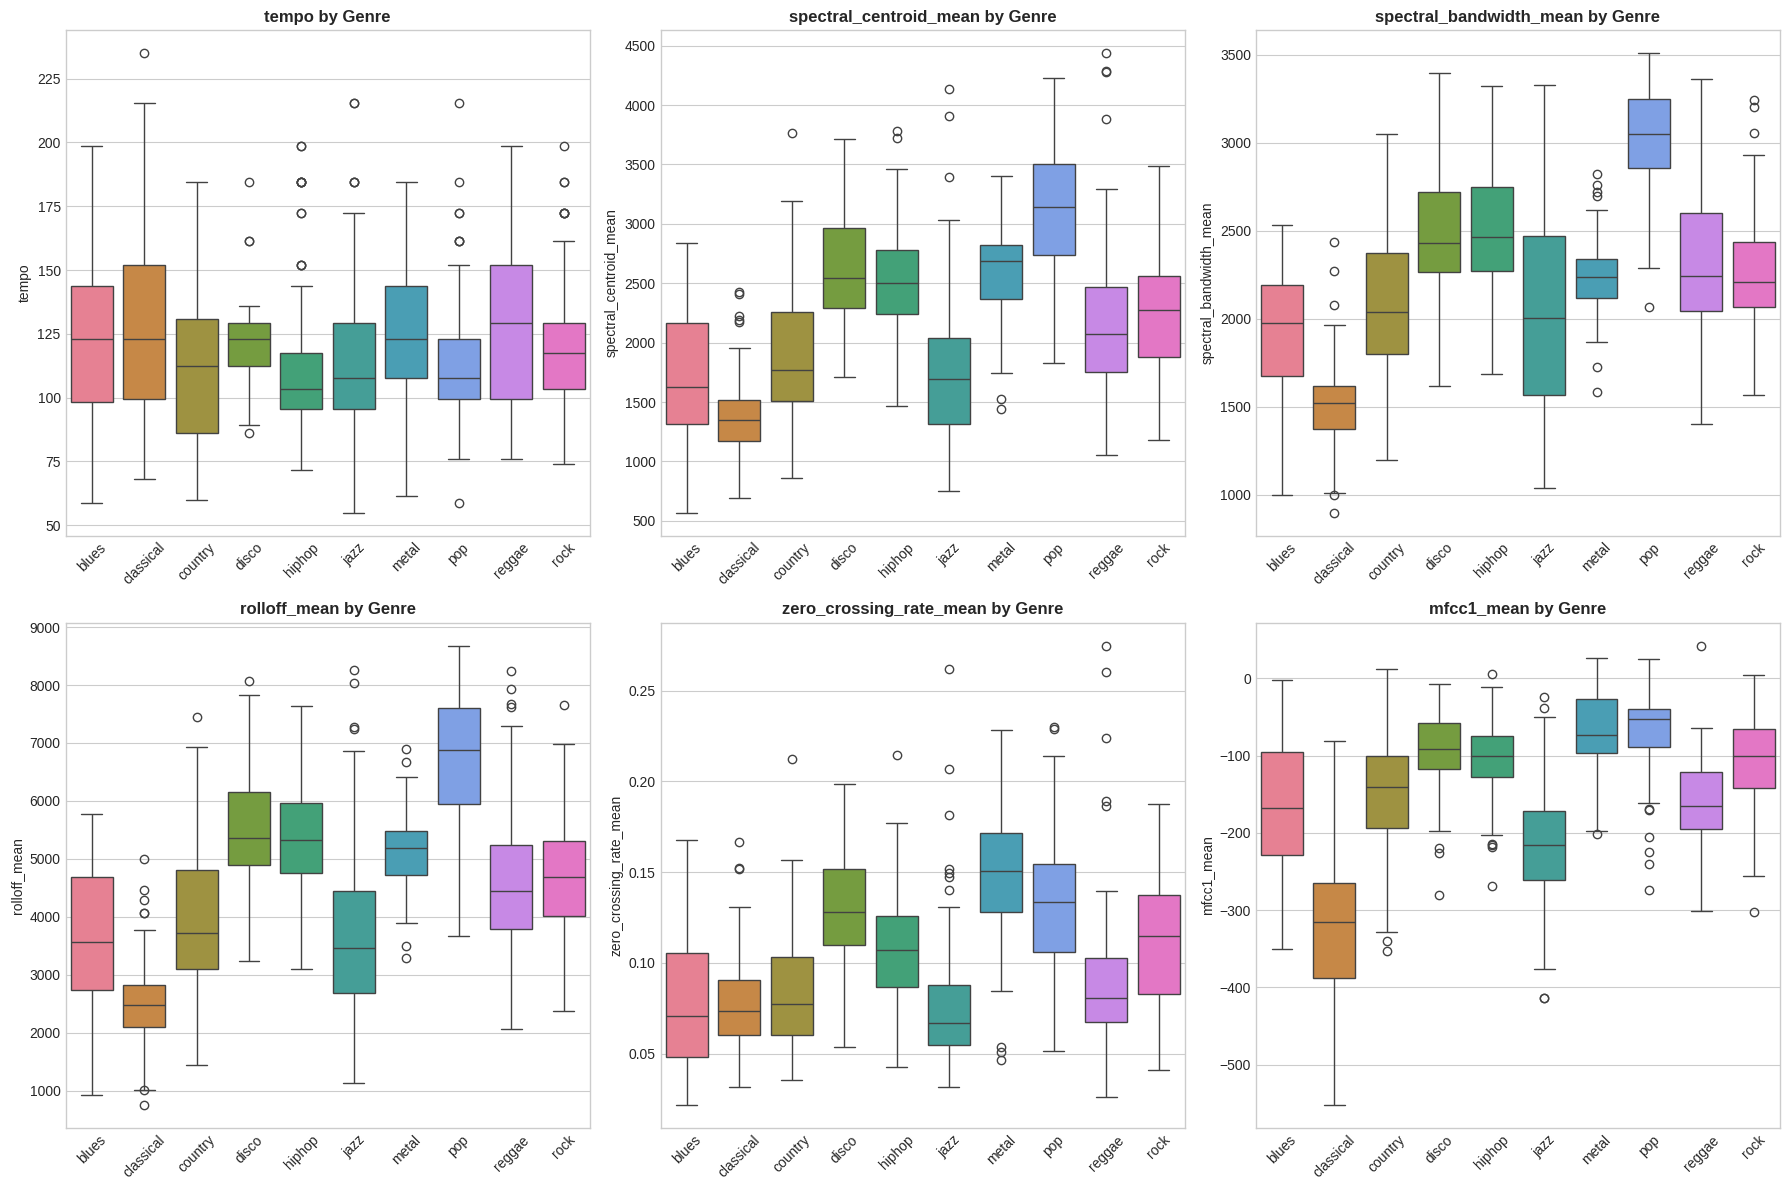

In [9]:
# Box plots for key features by genre
key_features = ['tempo', 'spectral_centroid_mean', 'spectral_bandwidth_mean', 
                'rolloff_mean', 'zero_crossing_rate_mean', 'mfcc1_mean']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(x='label', y=feature, data=df_30, ax=axes[i], palette='husl')
    axes[i].set_title(f'{feature} by Genre', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.4 Spectrogram Images Preview

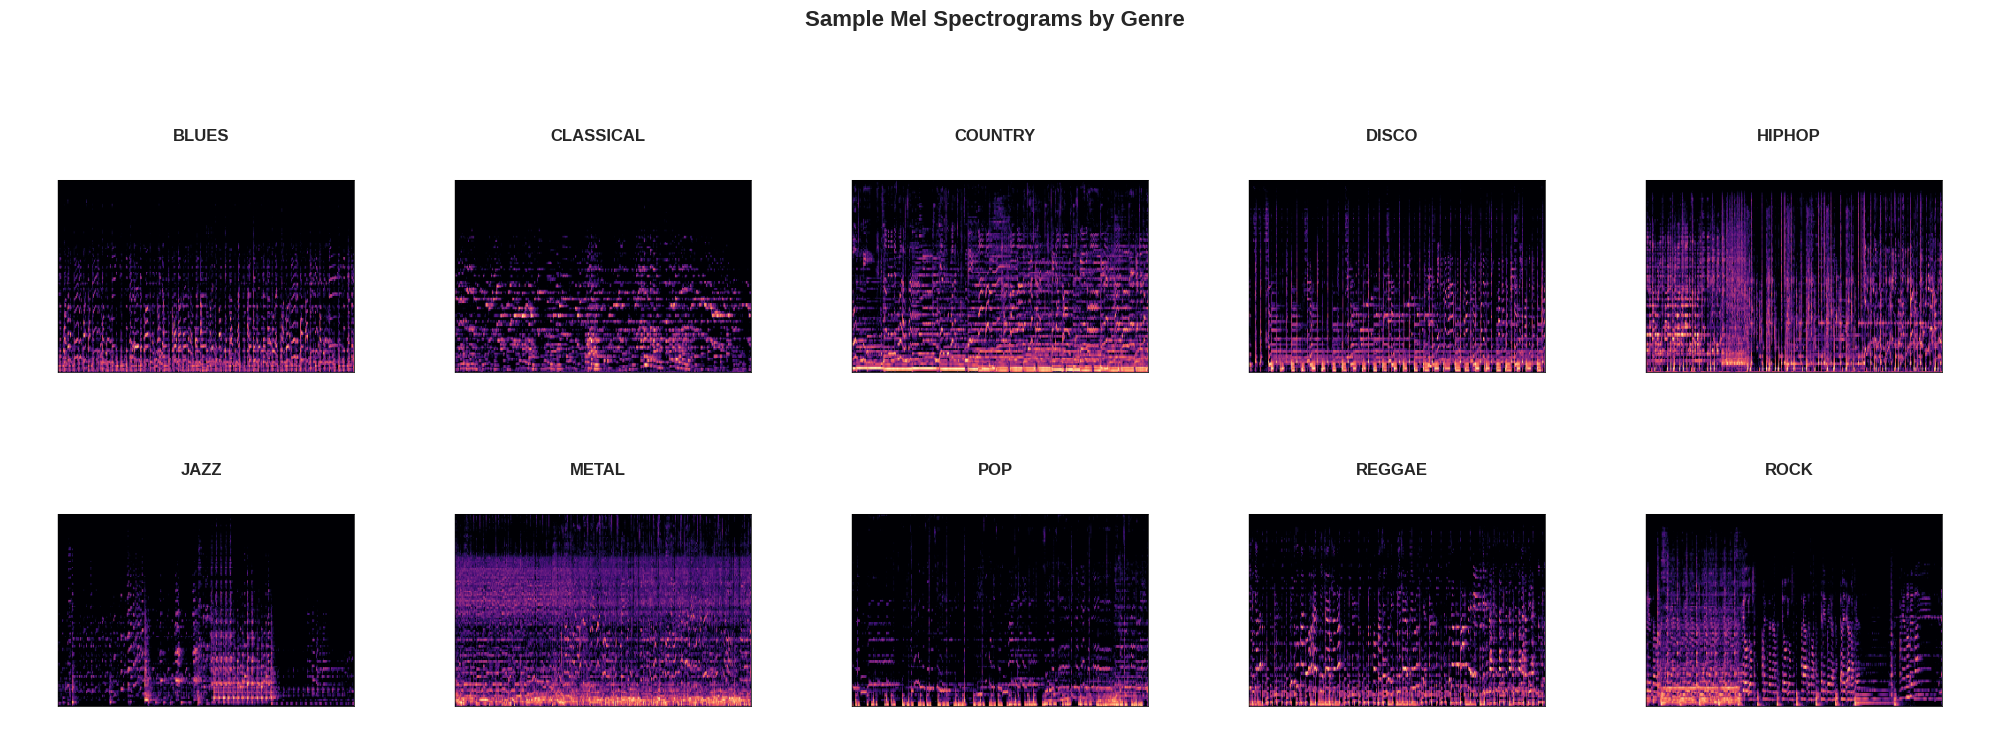


📷 Image dimensions: (288, 432, 3)


In [10]:
# Display sample spectrogram images from each genre
from tensorflow.keras.preprocessing.image import load_img

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, genre in enumerate(genres):
    genre_path = IMAGES_DIR / genre
    # Get first image from each genre
    img_files = sorted(os.listdir(genre_path))
    if img_files:
        img_path = genre_path / img_files[0]
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{genre.upper()}', fontsize=12, fontweight='bold')
        axes[i].axis('off')

plt.suptitle('Sample Mel Spectrograms by Genre', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Get image dimensions
sample_img = load_img(IMAGES_DIR / 'blues' / os.listdir(IMAGES_DIR / 'blues')[0])
print(f"\n📷 Image dimensions: {np.array(sample_img).shape}")

---

# Part 1: Tabular Machine Learning Approach

Using pre-extracted audio features (MFCCs, spectral features, etc.) for classification.

## 3. Data Preprocessing

In [11]:
# Prepare features and target
# Drop non-feature columns
drop_cols = ['filename', 'label', 'length']
X = df_30.drop(columns=drop_cols)
y = df_30['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("=" * 60)
print("📊 Data Preparation")
print("=" * 60)
print(f"Features shape: {X.shape}")
print(f"Target classes: {label_encoder.classes_}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist())

📊 Data Preparation
Features shape: (1000, 57)
Target classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']

Feature columns (57):
['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features scaled using StandardScaler")

Training set: 800 samples
Test set: 200 samples

✅ Features scaled using StandardScaler


## 4. Model Training & Evaluation

In [13]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(kernel='rbf', random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

# Store results
results = []

print("=" * 60)
print("🔄 Training Multiple Models...")
print("=" * 60)

for name, model in models.items():
    print(f"\n▶ Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f"   Accuracy: {accuracy:.4f} | F1: {f1:.4f} | CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Results DataFrame
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\n" + "=" * 60)
print("📊 Model Comparison Summary")
print("=" * 60)
results_df

🔄 Training Multiple Models...

▶ Training Logistic Regression...
   Accuracy: 0.7100 | F1: 0.7107 | CV: 0.7050 (+/- 0.0363)

▶ Training K-Nearest Neighbors...
   Accuracy: 0.6700 | F1: 0.6695 | CV: 0.6625 (+/- 0.0435)

▶ Training Support Vector Machine...
   Accuracy: 0.7350 | F1: 0.7340 | CV: 0.7075 (+/- 0.0297)

▶ Training Random Forest...
   Accuracy: 0.6850 | F1: 0.6756 | CV: 0.6900 (+/- 0.0527)

▶ Training Gradient Boosting...
   Accuracy: 0.6900 | F1: 0.6902 | CV: 0.6813 (+/- 0.0288)

📊 Model Comparison Summary


,Model,Accuracy,F1 Score,CV Mean,CV Std
2,Support Vector Machine,0.735,0.734019,0.70750,0.029686
0,Logistic Regression,0.710,0.710735,0.70500,0.036315
4,Gradient Boosting,0.690,0.690184,0.68125,0.028777
3,Random Forest,0.685,0.675566,0.69000,0.052678
1,K-Nearest Neighbors,0.670,0.669476,0.66250,0.043481


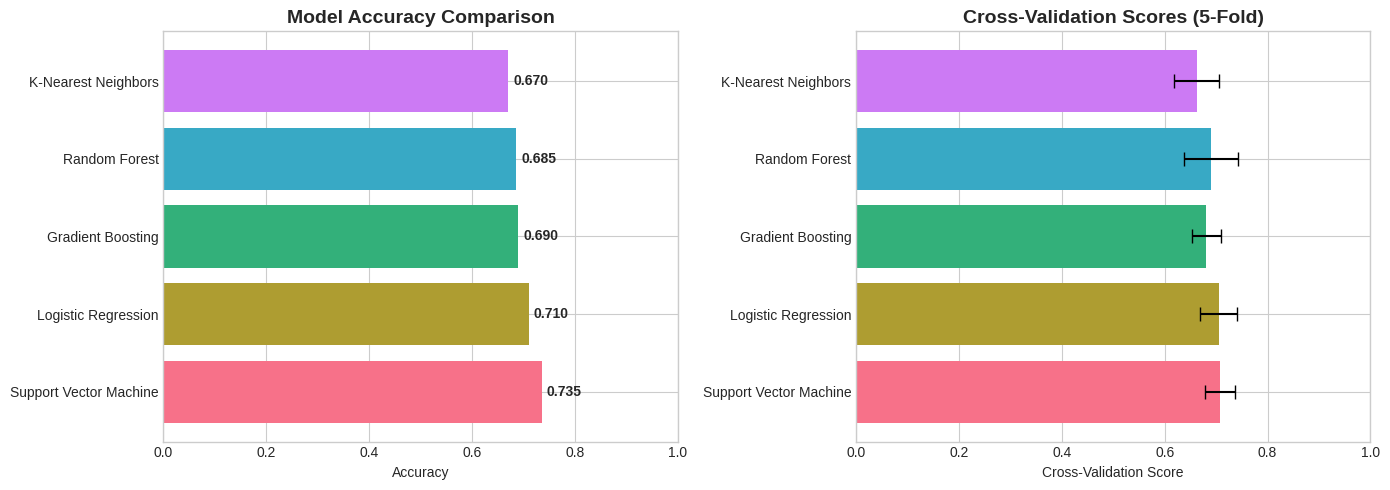

In [14]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = sns.color_palette('husl', n_colors=len(results_df))
bars = axes[0].barh(results_df['Model'], results_df['Accuracy'], color=colors)
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
for bar, acc in zip(bars, results_df['Accuracy']):
    axes[0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{acc:.3f}', va='center', fontweight='bold')

# Cross-validation scores with error bars
axes[1].barh(results_df['Model'], results_df['CV Mean'], 
             xerr=results_df['CV Std'], color=colors, capsize=5)
axes[1].set_xlabel('Cross-Validation Score')
axes[1].set_title('Cross-Validation Scores (5-Fold)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

### 4.1 Best Model Analysis

In [15]:
# Get best model based on accuracy
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print("\n" + "=" * 60)
print("📋 Classification Report")
print("=" * 60)

y_pred_best = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_best, 
                           target_names=label_encoder.classes_))

🏆 Best Model: Support Vector Machine

📋 Classification Report
              precision    recall  f1-score   support

       blues       0.82      0.70      0.76        20
   classical       0.95      1.00      0.98        20
     country       0.83      0.75      0.79        20
       disco       0.59      0.50      0.54        20
      hiphop       0.71      0.75      0.73        20
        jazz       0.71      0.85      0.77        20
       metal       0.80      0.80      0.80        20
         pop       0.78      0.70      0.74        20
      reggae       0.61      0.70      0.65        20
        rock       0.57      0.60      0.59        20

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.74      0.73      0.73       200



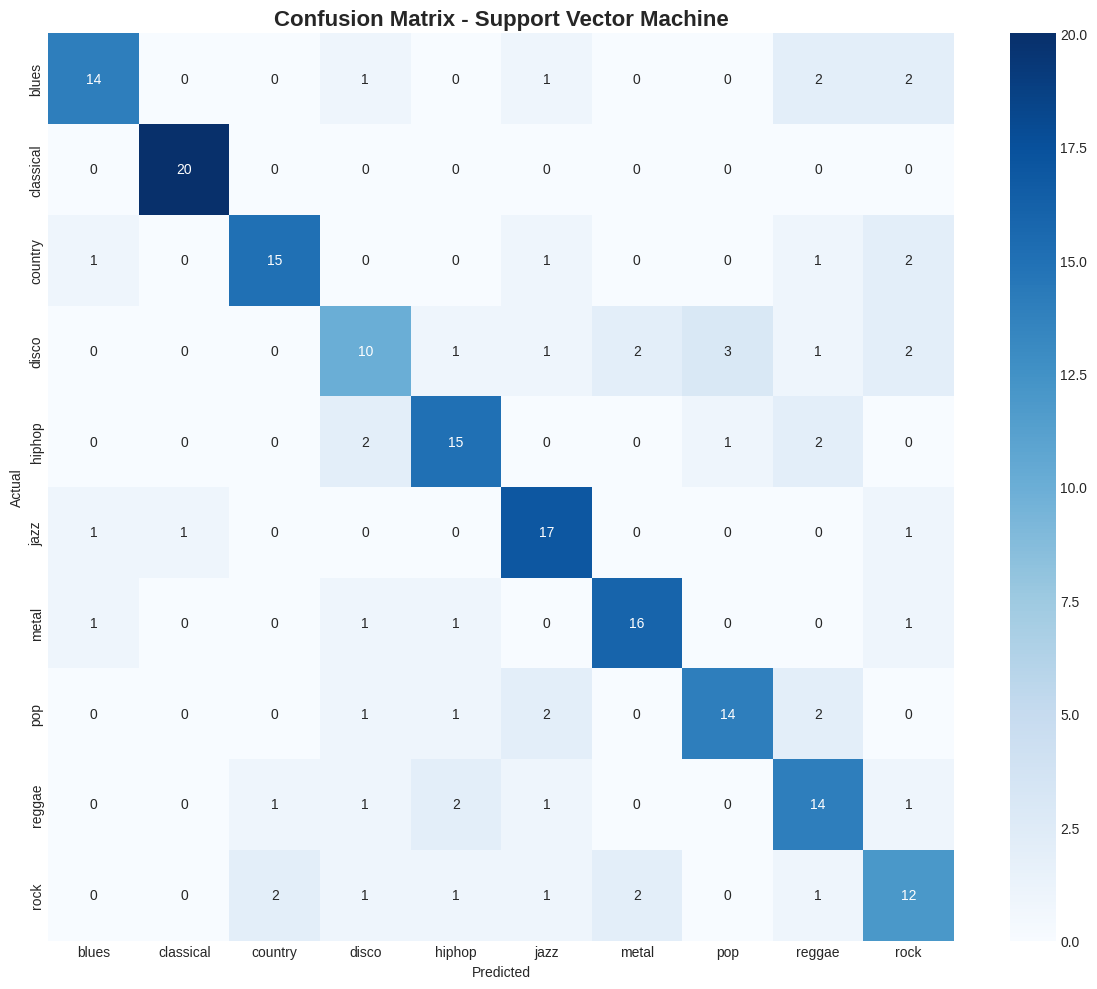

In [16]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### 4.2 Feature Importance (Random Forest)

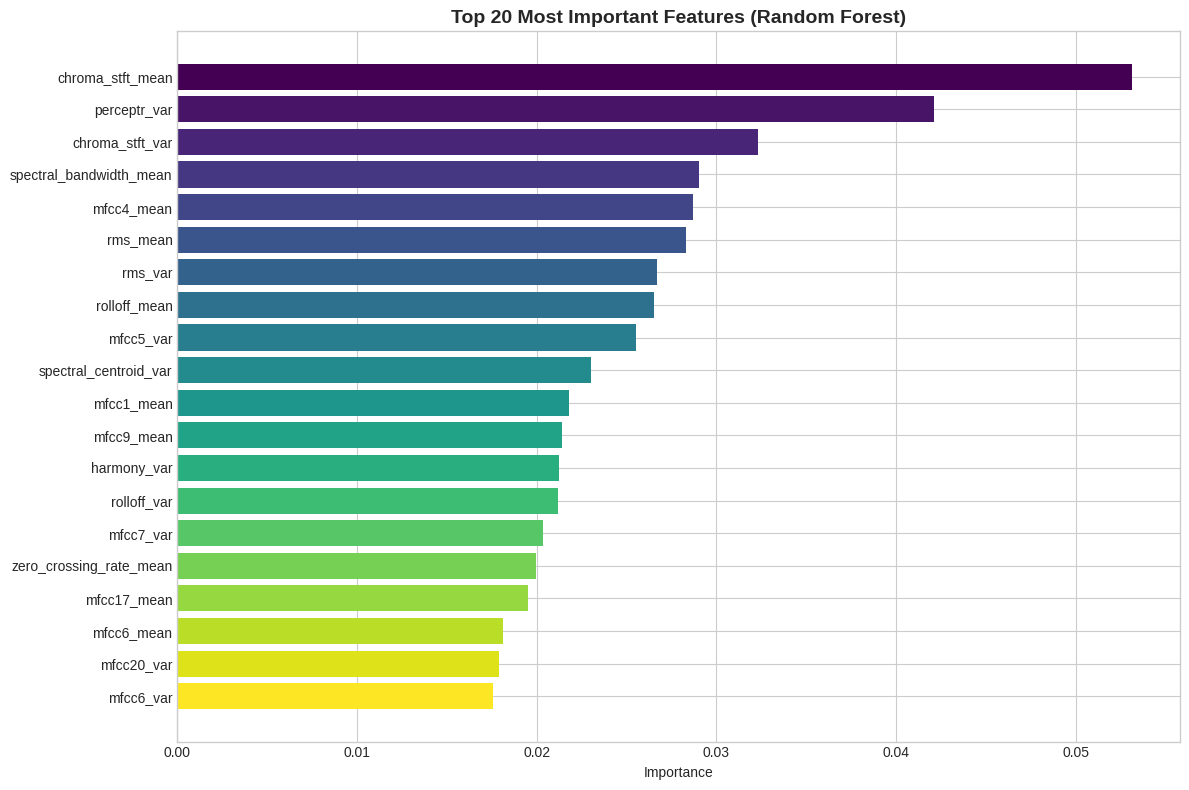


📊 Top 10 Features:
                feature  importance
       chroma_stft_mean    0.053135
           perceptr_var    0.042121
        chroma_stft_var    0.032322
spectral_bandwidth_mean    0.028999
             mfcc4_mean    0.028667
               rms_mean    0.028322
                rms_var    0.026670
           rolloff_mean    0.026520
              mfcc5_var    0.025503
  spectral_centroid_var    0.023039


In [17]:
# Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features:")
print(feature_importance.head(10).to_string(index=False))

---

# Part 2: CNN Approach with Spectrogram Images

## 5. Image Data Preparation

In [18]:
# Image parameters
IMG_HEIGHT = 288
IMG_WIDTH = 432
BATCH_SIZE = 32
EPOCHS_CNN = 50

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    IMAGES_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_STATE
)

# Validation generator
validation_generator = test_datagen.flow_from_directory(
    IMAGES_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_STATE
)

print("\n✅ Image data generators created")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Classes: {train_generator.class_indices}")

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.

✅ Image data generators created
Training samples: 800
Validation samples: 199
Classes: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


## 6. Custom CNN Model

In [20]:
def build_cnn_model(input_shape, num_classes):
    """
    Build a custom CNN model for music genre classification.
    """
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build model
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = 10

cnn_model = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)

# Compile model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(cnn_model.summary())

2026-02-04 22:29:11.768785: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 254803968 exceeds 10% of free system memory.
2026-02-04 22:29:11.808328: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 254803968 exceeds 10% of free system memory.
2026-02-04 22:29:11.847120: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 254803968 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 288, 432, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 288, 432, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 288, 432, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 288, 432, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 144, 216, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 216, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 144, 216, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 144, 216, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 144, 216, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 144, 216, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 72, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 108, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 108, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 72, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 36, 54, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 36, 54, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 36, 54, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 65,014,570 (248.01 MB)

 Trainable params: 65,011,114 (248.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

None


In [21]:
# Callbacks
cnn_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("=" * 60)
print("🔄 Training Custom CNN Model...")
print("=" * 60)

# Train model
cnn_history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS_CNN,
    validation_data=validation_generator,
    callbacks=cnn_callbacks,
    verbose=1
)

🔄 Training Custom CNN Model...
Epoch 1/50


2026-02-04 22:29:22.409208: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 254803968 exceeds 10% of free system memory.
2026-02-04 22:29:24.981550: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 509607936 exceeds 10% of free system memory.


25/25 ━━━━━━━━━━━━━━━━━━━━ 553s 22s/step - accuracy: 0.1663 - loss: 3.0774 - val_accuracy: 0.1005 - val_loss: 6.4284 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 312s 13s/step - accuracy: 0.2425 - loss: 2.6905 - val_accuracy: 0.1005 - val_loss: 4.5528 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 320s 13s/step - accuracy: 0.2800 - loss: 2.3637 - val_accuracy: 0.1005 - val_loss: 17.0896 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 314s 13s/step - accuracy: 0.3262 - loss: 2.1161 - val_accuracy: 0.1005 - val_loss: 16.7706 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 312s 12s/step - accuracy: 0.3187 - loss: 2.1238 - val_accuracy: 0.1005 - val_loss: 29.8190 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 312s 12s/step - accuracy: 0.3313 - loss: 2.0314 - val_accuracy: 0.1005 - val_loss: 36.3692 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3731 - loss: 1.8064 
Epoch 7: R

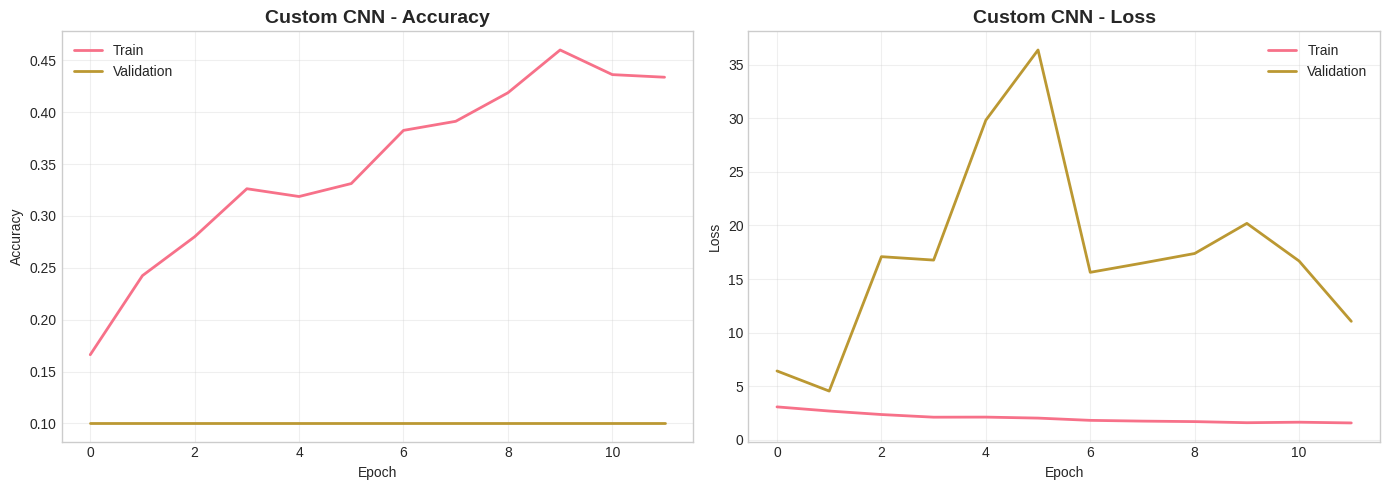

In [22]:
# Plot training history
def plot_training_history(history, title='Model'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(cnn_history, 'Custom CNN')

In [23]:
# Evaluate CNN model
print("\n" + "=" * 60)
print("📊 Custom CNN Evaluation")
print("=" * 60)

cnn_loss, cnn_accuracy = cnn_model.evaluate(validation_generator, verbose=0)
print(f"\nValidation Accuracy: {cnn_accuracy:.4f}")
print(f"Validation Loss: {cnn_loss:.4f}")

# Get predictions for confusion matrix
validation_generator.reset()
cnn_predictions = cnn_model.predict(validation_generator, verbose=0)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
cnn_true_classes = validation_generator.classes

# Classification report
class_names = list(train_generator.class_indices.keys())
print("\n📋 Classification Report:")
print(classification_report(cnn_true_classes, cnn_pred_classes, target_names=class_names))


📊 Custom CNN Evaluation

Validation Accuracy: 0.1005
Validation Loss: 4.5528

📋 Classification Report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.00      0.00      0.00        20
     country       0.10      1.00      0.19        20
       disco       0.00      0.00      0.00        20
      hiphop       0.40      0.10      0.16        20
        jazz       0.00      0.00      0.00        19
       metal       0.00      0.00      0.00        20
         pop       0.00      0.00      0.00        20
      reggae       0.00      0.00      0.00        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.11       199
   macro avg       0.05      0.11      0.03       199
weighted avg       0.05      0.11      0.03       199



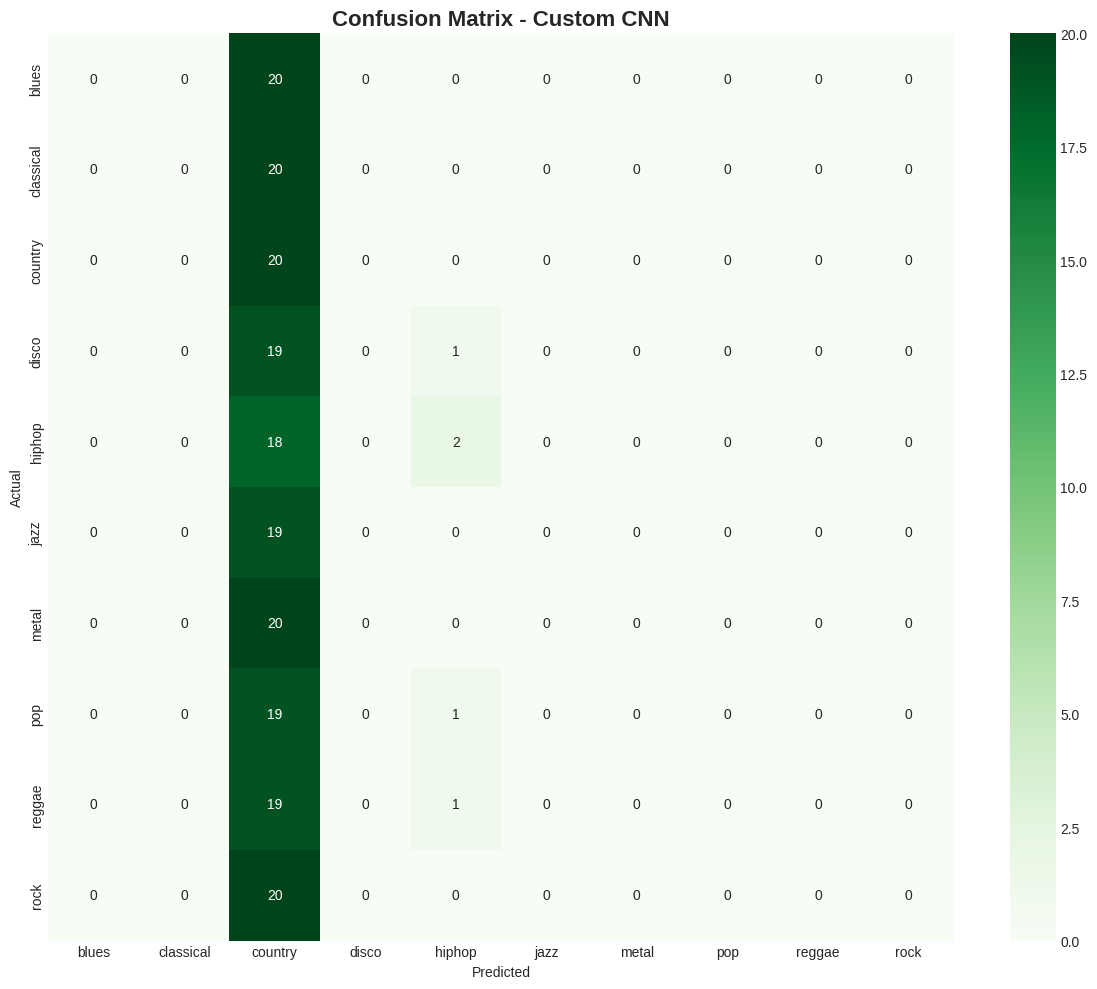

In [24]:
# CNN Confusion Matrix
plt.figure(figsize=(12, 10))
cnn_cm = confusion_matrix(cnn_true_classes, cnn_pred_classes)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - Custom CNN', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

---

# Part 3: Transfer Learning Approach

## 7. Transfer Learning with VGG16

In [25]:
# For transfer learning, we need to resize images to 224x224
TL_IMG_SIZE = 224

# Create new data generators for transfer learning
tl_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

tl_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator for transfer learning
tl_train_generator = tl_train_datagen.flow_from_directory(
    IMAGES_DIR,
    target_size=(TL_IMG_SIZE, TL_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_STATE
)

# Validation generator for transfer learning
tl_validation_generator = tl_test_datagen.flow_from_directory(
    IMAGES_DIR,
    target_size=(TL_IMG_SIZE, TL_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_STATE
)

print("\n✅ Transfer learning data generators created")

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.

✅ Transfer learning data generators created


In [ ]:
def build_transfer_learning_model(base_model_name='VGG16', input_shape=(224, 224, 3), num_classes=10):
    """
    Build a transfer learning model using a pre-trained base.
    """
    # Load pre-trained model without top layers
    if base_model_name == 'VGG16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Build model
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Build VGG16 transfer learning model
vgg16_model, vgg16_base = build_transfer_learning_model('VGG16', (TL_IMG_SIZE, TL_IMG_SIZE, 3), NUM_CLASSES)

# Compile
vgg16_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(vgg16_model.summary())

AttributeError: 'dict' object has no attribute 'Sequential'

In [ ]:
# Train VGG16 transfer learning model (Phase 1: Frozen base)
EPOCHS_TL = 30

tl_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("=" * 60)
print("🔄 Phase 1: Training VGG16 with Frozen Base...")
print("=" * 60)

vgg16_history_phase1 = vgg16_model.fit(
    tl_train_generator,
    epochs=EPOCHS_TL,
    validation_data=tl_validation_generator,
    callbacks=tl_callbacks,
    verbose=1
)

In [ ]:
# Fine-tuning: Unfreeze some layers
print("\n" + "=" * 60)
print("🔄 Phase 2: Fine-tuning VGG16...")
print("=" * 60)

# Unfreeze the last few layers of VGG16
vgg16_base.trainable = True

# Freeze all layers except the last 4
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate
vgg16_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
EPOCHS_FINETUNE = 20

vgg16_history_phase2 = vgg16_model.fit(
    tl_train_generator,
    epochs=EPOCHS_FINETUNE,
    validation_data=tl_validation_generator,
    callbacks=tl_callbacks,
    verbose=1
)

In [ ]:
# Plot combined training history
def combine_histories(h1, h2):
    """Combine two training histories."""
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return type('obj', (object,), {'history': combined})()

vgg16_history_combined = combine_histories(vgg16_history_phase1, vgg16_history_phase2)
plot_training_history(vgg16_history_combined, 'VGG16 Transfer Learning')

In [ ]:
# Evaluate VGG16 model
print("\n" + "=" * 60)
print("📊 VGG16 Transfer Learning Evaluation")
print("=" * 60)

vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(tl_validation_generator, verbose=0)
print(f"\nValidation Accuracy: {vgg16_accuracy:.4f}")
print(f"Validation Loss: {vgg16_loss:.4f}")

# Get predictions
tl_validation_generator.reset()
vgg16_predictions = vgg16_model.predict(tl_validation_generator, verbose=0)
vgg16_pred_classes = np.argmax(vgg16_predictions, axis=1)
vgg16_true_classes = tl_validation_generator.classes

# Classification report
print("\n📋 Classification Report:")
print(classification_report(vgg16_true_classes, vgg16_pred_classes, target_names=class_names))

In [ ]:
# VGG16 Confusion Matrix
plt.figure(figsize=(12, 10))
vgg16_cm = confusion_matrix(vgg16_true_classes, vgg16_pred_classes)
sns.heatmap(vgg16_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - VGG16 Transfer Learning', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

---

# Part 4: Results Comparison

## 8. Final Comparison & Summary

In [ ]:
# Calculate F1 scores for deep learning models
cnn_f1 = f1_score(cnn_true_classes, cnn_pred_classes, average='weighted')
vgg16_f1 = f1_score(vgg16_true_classes, vgg16_pred_classes, average='weighted')

# Compile final results
final_results = pd.DataFrame({
    'Approach': [
        f'Tabular ML ({best_model_name})',
        'Custom CNN',
        'VGG16 Transfer Learning'
    ],
    'Accuracy': [
        results_df.iloc[0]['Accuracy'],
        cnn_accuracy,
        vgg16_accuracy
    ],
    'F1 Score': [
        results_df.iloc[0]['F1 Score'],
        cnn_f1,
        vgg16_f1
    ],
    'Data Type': ['Audio Features', 'Spectrogram Images', 'Spectrogram Images']
}).sort_values('Accuracy', ascending=False)

print("=" * 60)
print("🏆 FINAL RESULTS COMPARISON")
print("=" * 60)
print(final_results.to_string(index=False))

In [ ]:
# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors for each approach
approach_colors = ['#3498db', '#2ecc71', '#e74c3c']

# Accuracy comparison
bars1 = axes[0].bar(final_results['Approach'], final_results['Accuracy'], 
                    color=approach_colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=15)
for bar, acc in zip(bars1, final_results['Accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.3f}', ha='center', fontweight='bold', fontsize=12)

# F1 Score comparison
bars2 = axes[1].bar(final_results['Approach'], final_results['F1 Score'], 
                    color=approach_colors, edgecolor='black', linewidth=2)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=15)
for bar, f1 in zip(bars2, final_results['F1 Score']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{f1:.3f}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Tabular ML
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[0].set_title(f'Tabular ML\n({best_model_name})', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Custom CNN
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_names,
            yticklabels=class_names)
axes[1].set_title('Custom CNN', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# VGG16
sns.heatmap(vgg16_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=class_names,
            yticklabels=class_names)
axes[2].set_title('VGG16 Transfer Learning', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Per-genre accuracy analysis
def get_per_class_accuracy(y_true, y_pred, class_names):
    """Calculate per-class accuracy."""
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return dict(zip(class_names, per_class_acc))

# Calculate per-class accuracy for each model
tabular_per_class = get_per_class_accuracy(y_test, y_pred_best, label_encoder.classes_)
cnn_per_class = get_per_class_accuracy(cnn_true_classes, cnn_pred_classes, class_names)
vgg16_per_class = get_per_class_accuracy(vgg16_true_classes, vgg16_pred_classes, class_names)

# Create DataFrame for comparison
per_class_df = pd.DataFrame({
    'Genre': class_names,
    'Tabular ML': [tabular_per_class.get(g, 0) for g in class_names],
    'Custom CNN': [cnn_per_class.get(g, 0) for g in class_names],
    'VGG16': [vgg16_per_class.get(g, 0) for g in class_names]
})

print("\n" + "=" * 60)
print("📊 Per-Genre Accuracy Comparison")
print("=" * 60)
print(per_class_df.to_string(index=False))

# Find hardest genres to classify
avg_accuracy = per_class_df[['Tabular ML', 'Custom CNN', 'VGG16']].mean(axis=1)
hardest_genres = per_class_df.loc[avg_accuracy.nsmallest(3).index, 'Genre'].tolist()
easiest_genres = per_class_df.loc[avg_accuracy.nlargest(3).index, 'Genre'].tolist()

print(f"\n❌ Hardest genres to classify: {hardest_genres}")
print(f"✅ Easiest genres to classify: {easiest_genres}")

In [ ]:
# Per-class accuracy heatmap
plt.figure(figsize=(12, 8))
per_class_matrix = per_class_df.set_index('Genre')[['Tabular ML', 'Custom CNN', 'VGG16']]
sns.heatmap(per_class_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
            vmin=0, vmax=1, linewidths=0.5)
plt.title('Per-Genre Accuracy Across Models', fontsize=16, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

## 9. Conclusions

In [ ]:
print("=" * 60)
print("📝 CONCLUSIONS")
print("=" * 60)

best_approach = final_results.iloc[0]

print(f"""
🎵 MUSIC GENRE CLASSIFICATION - SUMMARY

🏆 Best Performing Model: {best_approach['Approach']}
   - Accuracy: {best_approach['Accuracy']:.4f}
   - F1 Score: {best_approach['F1 Score']:.4f}

📊 Key Findings:

1. TABULAR ML APPROACH:
   - Uses pre-extracted audio features (MFCCs, spectral features)
   - Fast training, interpretable feature importance
   - Best model: {best_model_name}
   - Most important features: spectral_centroid, perceptr_var, mfcc coefficients

2. CUSTOM CNN APPROACH:
   - Uses mel spectrogram images as input
   - Learns hierarchical visual patterns
   - Requires more computational resources

3. TRANSFER LEARNING (VGG16):
   - Leverages pre-trained ImageNet features
   - Fine-tuning improves performance
   - Effective even with limited data

🔍 Genre Confusion Patterns:
   - Rock/Country often confused (similar acoustic characteristics)
   - Classical/Jazz sometimes confused (complex harmonic content)
   - Metal/Rock confusion (similar instrumentation)

💡 Recommendations:
   - For quick prototyping: Use tabular ML with pre-extracted features
   - For best accuracy: Ensemble multiple approaches
   - For deployment: Consider model size vs accuracy trade-off
""")

In [ ]:
# Save models (optional)
import joblib

# Save best tabular model
joblib.dump(best_model, 'best_tabular_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save CNN models
cnn_model.save('custom_cnn_model.keras')
vgg16_model.save('vgg16_transfer_model.keras')

print("✅ Models saved successfully!")
print("   - best_tabular_model.pkl")
print("   - feature_scaler.pkl")
print("   - label_encoder.pkl")
print("   - custom_cnn_model.keras")
print("   - vgg16_transfer_model.keras")